# Визуализация временных рядов


Проведем импорт необходимых библиотек

In [1]:
try:
    import pandas as pd 
except:
    !pip install pandas
finally:
    import pandas as pd 

In [2]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates#Date Parser

import seaborn as sns
sns.set_style('white')
sns.set(rc={'figure.figsize':(11, 4)})

## Загрузка данных в Pandas

урок вдохновлён данным репозиторием https://github.com/jenfly/opsd

В качестве  набор данных для практики рассмотрим часть набор данных [открытые данные энергетических систем](https://open-power-system-data.org/). Мы будем работать с данным относящимися ко временным рядам (https://data.open-power-system-data.org/time_series/). По приведенной ссылке можно найти описание набора данных. Также набор можно найти на странице официального репозитория: https://github.com/Open-Power-System-Data/time_series.

Для начала давайте попробуем загрузить последнюю версию набора данных.

In [3]:
# Download hourly data from OPSD website
url = 'https://data.open-power-system-data.org/time_series/2020-10-06/'
datafile = url + 'time_series_60min_singleindex.csv'
df_all = pd.read_csv(datafile, index_col='utc_timestamp', parse_dates=True, low_memory=False)
df_all.head()

,cet_cest_timestamp,AT_load_actual_entsoe_transparency,AT_load_forecast_entsoe_transparency,AT_price_day_ahead,AT_solar_generation_actual,AT_wind_onshore_generation_actual,BE_load_actual_entsoe_transparency,BE_load_forecast_entsoe_transparency,BE_solar_generation_actual,BE_wind_generation_actual,...,SI_load_actual_entsoe_transparency,SI_load_forecast_entsoe_transparency,SI_solar_generation_actual,SI_wind_onshore_generation_actual,SK_load_actual_entsoe_transparency,SK_load_forecast_entsoe_transparency,SK_solar_generation_actual,SK_wind_onshore_generation_actual,UA_load_actual_entsoe_transparency,UA_load_forecast_entsoe_transparency
utc_timestamp,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,2015-01-01T00:00:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 00:00:00+00:00,2015-01-01T01:00:00+0100,5946.0,6701.0,35.0,NaN,69.0,9484.0,9897.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 01:00:00+00:00,2015-01-01T02:00:00+0100,5726.0,6593.0,45.0,NaN,64.0,9152.0,9521.0,NaN,734.81,...,1045.47,816.0,NaN,1.17,2728.0,2860.0,3.8,NaN,NaN,NaN
2015-01-01 02:00:00+00:00,2015-01-01T03:00:00+0100,5347.0,6482.0,41.0,NaN,65.0,8799.0,9135.0,NaN,766.64,...,1004.79,805.0,NaN,1.04,2626.0,2810.0,3.8,NaN,NaN,NaN
2015-01-01 03:00:00+00:00,2015-01-01T04:00:00+0100,5249.0,6454.0,38.0,NaN,64.0,8567.0,8909.0,NaN,733.13,...,983.79,803.0,NaN,1.61,2618.0,2780.0,3.8,NaN,NaN,NaN


Из всего набора выделим только данные относящиеся к целевой стране.  В качестве примера рассмотрим германию. В качестве периода анализа возьмём период с 2015 по 2019 годы.

In [4]:
def extract_country(df_all, country_code, year_min=None, year_max=None):
    """Extract data for a single country"""
    
    # List of columns to extract
    columns = [col for col in df_all.columns if col.startswith(country_code)]
    
    # Extract columns and remove country codes from column labels
    columns_map = {col : col[3:] for col in columns}
    df_out = df_all[columns].rename(columns=columns_map)
    
    # Exclude years outside of specified range, if any
    if year_min is not None:
        df_out = df_out[df_out.index.year >= year_min]
    if year_max is not None:
        df_out = df_out[df_out.index.year <= year_max]
        
    return df_out
df_hrly = extract_country(df_all, country_code='DE', year_min=2015, year_max=2019)
df_hrly

,load_actual_entsoe_transparency,load_forecast_entsoe_transparency,solar_capacity,solar_generation_actual,solar_profile,wind_capacity,wind_generation_actual,wind_profile,wind_offshore_capacity,wind_offshore_generation_actual,...,tennet_load_actual_entsoe_transparency,tennet_load_forecast_entsoe_transparency,tennet_solar_generation_actual,tennet_wind_generation_actual,tennet_wind_offshore_generation_actual,tennet_wind_onshore_generation_actual,transnetbw_load_actual_entsoe_transparency,transnetbw_load_forecast_entsoe_transparency,transnetbw_solar_generation_actual,transnetbw_wind_onshore_generation_actual
utc_timestamp,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00+00:00,41151.0,39723.0,37248.0,NaN,NaN,27913.0,8852.0,0.3171,667.0,517.0,...,13841.0,13362.0,NaN,3866.0,469.0,3398.0,5307.0,4703.0,NaN,5.0
2015-01-01 01:00:00+00:00,40135.0,38813.0,37248.0,NaN,NaN,27913.0,9054.0,0.3244,667.0,514.0,...,13267.0,12858.0,NaN,3974.0,466.0,3508.0,5087.0,4562.0,NaN,7.0
2015-01-01 02:00:00+00:00,39106.0,38490.0,37248.0,NaN,NaN,27913.0,9070.0,0.3249,667.0,518.0,...,12702.0,12611.0,NaN,4194.0,470.0,3724.0,4906.0,4517.0,NaN,8.0
2015-01-01 03:00:00+00:00,38765.0,38644.0,37248.0,NaN,NaN,27913.0,9163.0,0.3283,667.0,520.0,...,12452.0,12490.0,NaN,4446.0,473.0,3973.0,4865.0,4601.0,NaN,11.0
2015-01-01 04:00:00+00:00,38941.0,38773.0,37248.0,NaN,NaN,27913.0,9231.0,0.3307,667.0,520.0,...,12454.0,12464.0,NaN,4671.0,474.0,4198.0,4685.0,4519.0,NaN,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00+00:00,47493.0,54131.0,NaN,0.0,NaN,NaN,8875.0,NaN,NaN,873.0,...,14753.0,15838.0,0.0,1764.0,274.0,1490.0,5676.0,5584.0,0.0,126.0
2019-12-31 20:00:00+00:00,45842.0,51764.0,NaN,0.0,NaN,NaN,7652.0,NaN,NaN,704.0,...,14018.0,15145.0,0.0,1384.0,151.0,1233.0,5507.0,5564.0,0.0,109.0
2019-12-31 21:00:00+00:00,45501.0,50569.0,NaN,0.0,NaN,NaN,7283.0,NaN,NaN,575.0,...,14064.0,15275.0,0.0,1223.0,57.0,1166.0,5530.0,5522.0,0.0,152.0


Нам понадобятся не все колонки, поэтому выделим необходимые, кроме того приведем колонки к более интерпретируемому виду

In [5]:
def transform_dataframe(df, cols_map):
    # Rename columns for convenience
    df = df[list(cols_map.keys())].rename(columns=cols_map)
    # Convert from MW to GW
    df = df / 1000
    df = df.resample('D').sum(min_count=24)
    df = df.rename_axis('Date')
    df.index = df.index.strftime('%Y-%m-%d')
    return df

cols_map = {'load_actual_entsoe_transparency' : 'Consumption',
            'wind_generation_actual' : 'Wind',
            'solar_generation_actual' : 'Solar'}
df_daily = transform_dataframe(df_hrly, cols_map)

# Compute wind + solar generation
df_daily['Wind+Solar'] = df_daily[['Wind', 'Solar']].sum(axis=1, skipna=False)
df_daily.to_csv('de_data.csv')
df_daily.head()

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2015-01-01,1088.317,325.165,NaN,NaN
2015-01-02,1246.588,603.554,7.757,611.311
2015-01-03,1117.554,462.955,7.237,470.192
2015-01-04,1081.980,385.023,19.982,405.005
2015-01-05,1325.920,216.540,26.522,243.062


Теперь набор представляет собой ежедневное потребление электричества (в гига-Ваттах в час) в Германии. Набор включает следующие временные ряды в виде колонок:
* Date — дата в формате гггг-мм-дд;
* Consumption — Общее потребление, ГВт/ч;
* Wind — Потребление ветряной энергии, ГВт/ч;
* Solar — Потребление солнечной энергии, ГВт/ч;
* Wind+Solar — Потребление энергии из альтернативных источников, ГВт/ч.

Проведем анализ сформированного набора данных

In [6]:

path_ts = 'de_data.csv'

df = pd.read_csv(path_ts)

df.sample(5, random_state=0)

,Date,Consumption,Wind,Solar,Wind+Solar
793,2017-03-04,1224.314,253.250,99.948,353.198
789,2017-02-28,1509.014,602.221,49.109,651.330
118,2015-04-29,1365.365,153.288,188.720,342.008
318,2015-11-15,1176.237,530.791,21.279,552.070
891,2017-06-10,1132.742,89.475,214.438,303.913


Размер набора данных

In [7]:
print(df.shape)

(1826, 5)


Информация о колонках в наборе   

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826 entries, 0 to 1825
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         1826 non-null   object 
 1   Consumption  1826 non-null   float64
 2   Wind         1819 non-null   float64
 3   Solar        1818 non-null   float64
 4   Wind+Solar   1817 non-null   float64
dtypes: float64(4), object(1)
memory usage: 71.5+ KB


Описание суммарных статистик данных

In [9]:
df.describe()

,Consumption,Wind,Solar,Wind+Solar
count,1826.000000,1819.000000,1818.000000,1817.000000
mean,1340.623081,267.842699,103.386051,371.257950
std,156.544793,192.922094,66.797470,178.690531
min,934.864000,16.482000,4.989000,27.529000
25%,1213.262000,120.906500,38.559500,242.188000
50%,1374.256000,211.989000,101.705500,338.443000
75%,1455.366500,364.868000,159.751250,470.921000
max,1636.406000,998.899000,264.538000,1034.494000


типы данных

In [10]:
df.dtypes

Date            object
Consumption    float64
Wind           float64
Solar          float64
Wind+Solar     float64
dtype: object

Введение индексов-дат

In [11]:
df.Date = pd.to_datetime(df.Date)
df.set_index('Date', inplace=True)
df.sample(15, random_state=0)

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2017-03-04,1224.314,253.250,99.948,353.198
2017-02-28,1509.014,602.221,49.109,651.330
2015-04-29,1365.365,153.288,188.720,342.008
2015-11-15,1176.237,530.791,21.279,552.070
2017-06-10,1132.742,89.475,214.438,303.913
2017-06-03,1126.704,97.750,165.064,262.814
2015-12-14,1479.403,110.010,27.409,137.419
2019-10-15,1441.266,214.059,101.408,315.467
2016-04-27,1456.925,390.802,106.074,496.876


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2015-01-01 to 2019-12-31
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Consumption  1826 non-null   float64
 1   Wind         1819 non-null   float64
 2   Solar        1818 non-null   float64
 3   Wind+Solar   1817 non-null   float64
dtypes: float64(4)
memory usage: 71.3 KB


Отметим, что на самом деле можно было сразу загрузить данные в таком виде, чтобы индексы были датами

In [13]:
df = pd.read_csv(path_ts, parse_dates=['Date'], index_col="Date")
df.head()

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2015-01-01,1088.317,325.165,NaN,NaN
2015-01-02,1246.588,603.554,7.757,611.311
2015-01-03,1117.554,462.955,7.237,470.192
2015-01-04,1081.980,385.023,19.982,405.005
2015-01-05,1325.920,216.540,26.522,243.062



Данные обработанные в форме дат `DateTimeIndex` позволяют работать с индексом как с датой


In [14]:
print(df.index.day)
print(df.index.weekday)
print(df.index.year)

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
            ...
            22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
           dtype='int64', name='Date', length=1826)
Int64Index([3, 4, 5, 6, 0, 1, 2, 3, 4, 5,
            ...
            6, 0, 1, 2, 3, 4, 5, 6, 0, 1],
           dtype='int64', name='Date', length=1826)
Int64Index([2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015,
            ...
            2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019],
           dtype='int64', name='Date', length=1826)


Теперь мы можем обращаться к данным по дате

In [15]:
df.loc['2017-08-10']

Consumption    1342.278
Wind            100.274
Solar            71.162
Wind+Solar      171.436
Name: 2017-08-10 00:00:00, dtype: float64

или по выборке дат

In [16]:
df.loc['2014-12-31':'2015-01-22']

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2015-01-01,1088.317,325.165,NaN,NaN
2015-01-02,1246.588,603.554,7.757,611.311
2015-01-03,1117.554,462.955,7.237,470.192
2015-01-04,1081.980,385.023,19.982,405.005
2015-01-05,1325.920,216.540,26.522,243.062
2015-01-06,1331.916,117.227,32.888,150.115
2015-01-07,1442.712,227.204,17.114,244.318
2015-01-08,1474.375,440.318,8.599,448.917
2015-01-09,1459.409,641.729,6.822,648.551


а также обращаться к конкретной колонке по дате

In [17]:
df.loc['2015-12-20':'2015-12-25', 'Wind']

Date
2015-12-20    370.889
2015-12-21    583.385
2015-12-22    638.509
2015-12-23    552.048
2015-12-24    450.480
2015-12-25    420.503
Name: Wind, dtype: float64

Или использовать колонку как переменную

In [18]:
df.Wind.loc['2015-12-20':'2015-12-25']

Date
2015-12-20    370.889
2015-12-21    583.385
2015-12-22    638.509
2015-12-23    552.048
2015-12-24    450.480
2015-12-25    420.503
Name: Wind, dtype: float64

а также к каждой колонке можно обращаться по ключу

In [19]:
df[['Wind']].loc['2015-12-20':'2015-12-25']

,Wind
Date,
2015-12-20,370.889
2015-12-21,583.385
2015-12-22,638.509
2015-12-23,552.048
2015-12-24,450.480
2015-12-25,420.503


In [20]:
df['Wind'].loc['2015-12-20':'2015-12-25']

Date
2015-12-20    370.889
2015-12-21    583.385
2015-12-22    638.509
2015-12-23    552.048
2015-12-24    450.480
2015-12-25    420.503
Name: Wind, dtype: float64

также можно обращаться по индексу чрез метод iloc

In [21]:
df.iloc[0:2,0:3]

,Consumption,Wind,Solar
Date,,,
2015-01-01,1088.317,325.165,NaN
2015-01-02,1246.588,603.554,7.757


Данные можно представлять с нужной частотой при помощи метода `asfreq`, например с частотой `D` - день, `W`,`M`,`Y` для недели, месяца и года соответственно.

In [22]:
df[['Wind']].loc['2015-10-20':'2015-12-25'].asfreq('W')

,Wind
Date,
2015-10-25,107.528
2015-11-01,77.941
2015-11-08,317.087
2015-11-15,530.791
2015-11-22,295.045
2015-11-29,696.636
2015-12-06,589.628
2015-12-13,288.092
2015-12-20,370.889


можно сделать обращение по месяцу с периодом 1 неделя

In [23]:
df.loc['2016-02'].asfreq('W')

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2016-02-07,1158.086,515.965,38.073,554.038
2016-02-14,1179.309,280.405,26.907,307.312
2016-02-21,1192.219,641.776,22.521,664.297
2016-02-28,1155.177,187.644,71.204,258.848


или точно также с использованием открытой нотации обращения к массиву

In [24]:
df.loc['2015':].asfreq('Y')

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2015-12-31,1122.732,306.450,20.226,326.676
2016-12-31,1146.908,315.059,34.580,349.639
2017-12-31,1061.793,721.172,19.979,741.151
2018-12-31,1148.098,245.130,9.327,254.457
2019-12-31,1124.933,425.225,36.562,461.787


Полагаем, что в данном случае будет визуально правильней поменять индексы на значение года

In [25]:
df.loc['2012':].asfreq('Y').set_index(df.loc['2012':].asfreq('Y').index.year)

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2015,1122.732,306.450,20.226,326.676
2016,1146.908,315.059,34.580,349.639
2017,1061.793,721.172,19.979,741.151
2018,1148.098,245.130,9.327,254.457
2019,1124.933,425.225,36.562,461.787


Для индексов в формате дат также доступно группирование  методом ``` groupby```. Группирование ``` groupby``` происходит по заданным периодам, например `W`, 'Y' или `A` (год), `'2y'` (по 2 года) и т.д.


Часто после использования методов  ``` groupby```, ```asfreq```, а также ``` groupby``` используется некоторая функция итога, например,  `sum`, `mean`, `median` or `std`.  

In [26]:
df.groupby(pd.Grouper(freq='1y')).sum()

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2015-12-31,479496.047,77172.286,34779.771,111419.348
2016-12-31,486995.370,74996.242,34146.371,109089.308
2017-12-31,492116.437,102670.983,35882.978,138553.961
2018-12-31,498895.226,108564.492,41231.973,149796.465
2019-12-31,490474.666,123801.867,41914.747,165716.614


In [27]:
df.resample('1w').median().head(3)

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2015-01-04,1102.9355,423.989,7.757,470.192
2015-01-11,1331.9160,440.318,19.811,448.917
2015-01-18,1462.7150,406.982,21.405,425.088


In [28]:
df.asfreq('1w').head(3)

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2015-01-04,1081.980,385.023,19.982,405.005
2015-01-11,1162.956,630.378,19.811,650.189
2015-01-18,1139.695,127.215,31.259,158.474


The full list of frequencies with its description can be find in this book
https://jakevdp.github.io/PythonDataScienceHandbook/03.11-working-with-time-series.html


Также, полагаем, что в наборе достаточно много значений `NaN`. Давайте их уберем. Для этого в `Pandas` есть несколько инструментов, в том числе  ```ffill```, ```bfill``` для заполнения пропусков соответственно следующими или предыдущими значениями, например можно использовать  метод так ```.asfreq('D', method='ffill')```. Также возможны использования методов удаления пропусков `dropna` или заполнения заданными значениями `filna`. Если используется метод `dropna`, то из данных будет удалена вся строка с пропуском.
    
Давайте для начала посмотрим сколько у нас `NaN`  значений. 
Для этого можно использовать или метод `isnull` или `isna`
.

In [29]:
df.isna().sum()

Consumption    0
Wind           7
Solar          8
Wind+Solar     9
dtype: int64

In [30]:
df.fillna(0, inplace=True)
df.head(3)

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2015-01-01,1088.317,325.165,0.000,0.000
2015-01-02,1246.588,603.554,7.757,611.311
2015-01-03,1117.554,462.955,7.237,470.192


## Визуализация временного ряда


Для начала давайте посмотрим на наиболее простой тип визуализации для одного из столбцов наших данных

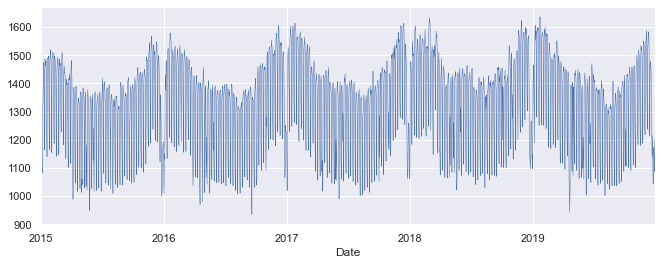

In [31]:
df['Consumption'].plot(linewidth=0.5);

В наших данных есть составляющее общего потребления, солнечной и ветряной энергии. Полагаем, что нам может потребоваться столбец, соответствующий другим источникам (не альтернативным).

In [32]:
df['Traditional'] = df['Consumption'] - df['Solar'] - df['Wind'] 

Также давайте попробуем визуализировать и остальные столбцы

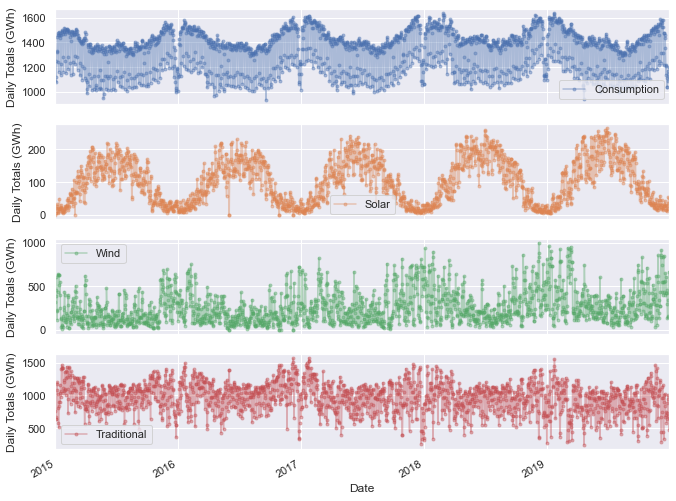

In [33]:
cols_plot = ['Consumption', 'Solar', 'Wind','Traditional']
axes = df[cols_plot].plot(marker='.', alpha=0.4, linestyle='-', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('Daily Totals (GWh)')

Теперь попробуем провести визуализацию на одном графике, с периодом 1 месяц 

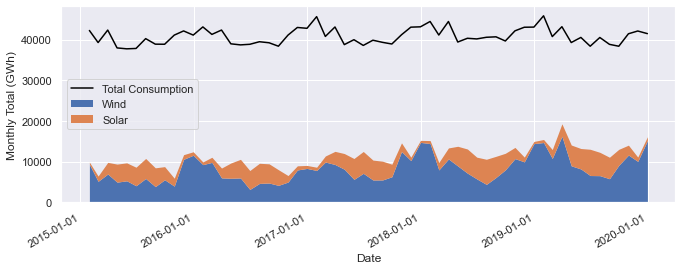

In [34]:
df_monthly = df.resample('M').sum(min_count=7)


fig, ax = plt.subplots()
ax.plot(df_monthly['Consumption'], color='black', label='Total Consumption')

df_monthly[['Wind', 'Solar']].plot.area(ax=ax, linewidth=0)

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.legend()
ax.set_ylabel('Monthly Total (GWh)');



Анализ полученных графиков показывает следующее:
* Все три графика осциллируют во времени в течение года. Рискнем предположить, что это связано с сезонностью и изменением погоды. 
* Потребление электроэнергии выше зимой и ниже летом.
* Потребление энергии имеет 2 сезонных составляющих:
  * основная, с  примерным диапазоном значений 1300-1500 ГВт 
  * дополнительная со значениями порядка 1100 ГВт, которая предположительно связана с изменением потребления в течение неделе. Это также подтверждается заметным снижением потребления в начале каждого года. 
* Пик производства солнечной энергии приходится на лето.
* Пик производства ветряной энергии приходится на зиму, причем колебания этого ряда куда более подвержены дисперсии. Полагаем, что это связано с погодным фактором.
* Значение альтернативных источников энергии растет, но очень медленно.
* Общее электропотребление, а также потребление из альтернативных источников имеют растущий тренд, тогда как тренд традиционных источников - спадающий.




Анализ общего потребления

Давайте подробней изучить сезонность по подробнее.
Для анализа гипотезы о наличии двух составляющих в общем потреблении давайте посмотрим на распределение значений.

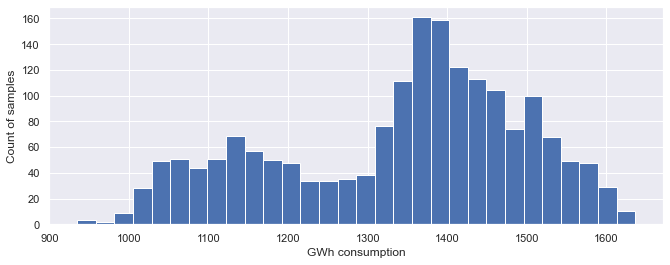

In [35]:
ax = df.Consumption.hist(bins=30)
# ax = df.Consumption.plot(kind='kde' )
ax.set_ylabel('Count of samples')
ax.set_xlabel('GWh consumption')
plt.show()

В распределении мы видим две составляющих, предположительно соответствующих двум периодам в данных. Пики этих составляющих приходятся на 1100 и 1400 ГВт. 
   

построим график потребления для периода в 2 месяца, включая начала и конец года


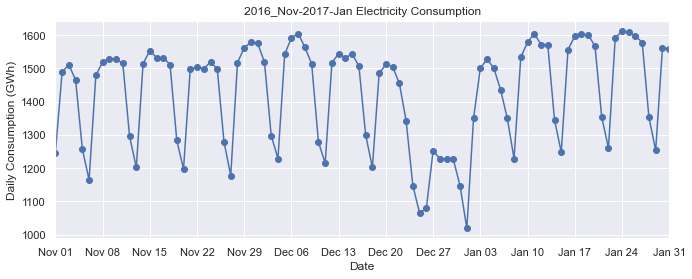

In [36]:
ax = df.loc['2016-11':'2017-01', 'Consumption'].plot(marker='o', linestyle='-')
ax.set_ylabel('Daily Consumption (GWh)')
ax.set_title('2016_Nov-2017-Jan Electricity Consumption')

# For more convinient ticks (week ticks)
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
# Format 3-letter month name and day number
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.show()

Действительно у нас имеется две сезонных компоненты.  Спад потребления связан с выходными). Однако, Потребление во время смены годов можно считать или аномалией или третьей составляющей (что возможно правильней). Проверим гипотезу о 3 составляющей. Для этого используем скользящее среднее.

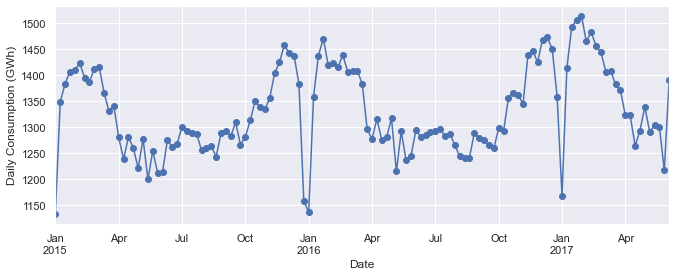

In [37]:
ax = df.loc['2013-10':'2017-05', 'Consumption'].\
    resample('W').mean().plot(marker='o', linestyle='-',linewidth=1.5)
ax.set_ylabel('Daily Consumption (GWh)')
plt.show()

Анализ потребления ветровой энергии

Также давайте проверим наличие тренда у ветровой составляющей (полагаем, что тут тренд не очевиден). Для этого используем скользящее вреднее при помощи метода `rolling`. Данный метод можно выполнить с заданным периодом, в частях года или днях. Отметим, что также можно воспользоваться методом скользящего среднего


<AxesSubplot:xlabel='Date'>

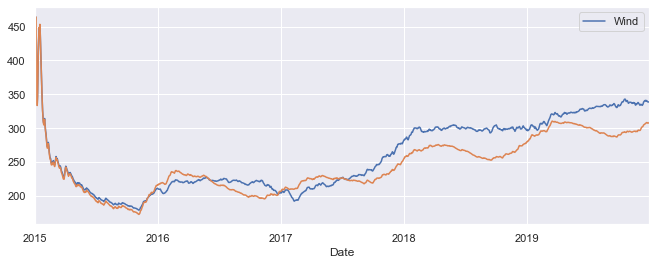

In [38]:
df[['Wind']].rolling('365d').mean().plot( linewidth=1.5, );
df.Wind.ewm(halflife=365, min_periods=0,adjust=True).mean().plot()



Также проверим тренд при помощи построения BBox

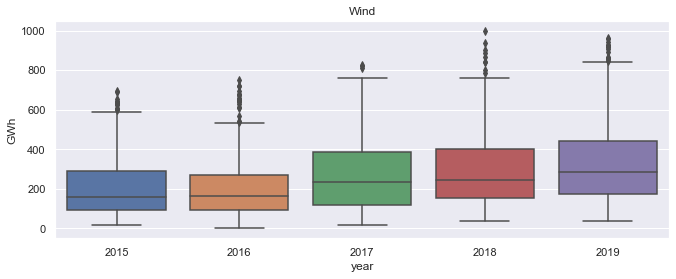

In [39]:
ax = sns.boxplot(data=df, x=df.index.year, y='Wind')
ax.set_ylabel('GWh')
ax.set_xlabel('year')
ax.set_title('Wind')
plt.show()


Отметим, что по мимо BBox можно также воспользоваться альтернативным отображением

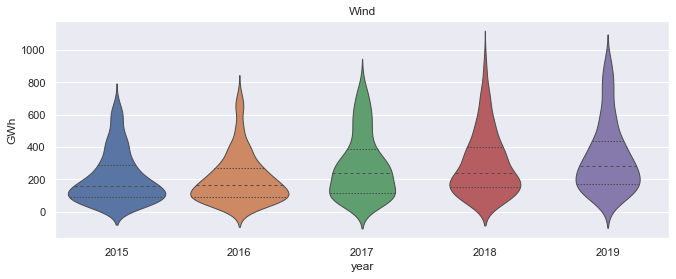

In [40]:
ax=sns.violinplot(data=df, x=df.index.year, y='Wind',
               split=True, inner="quart", linewidth=1, )
ax.set_ylabel('GWh')
ax.set_xlabel('year')
ax.set_title('Wind')
plt.show()

Однако, также можно проверить гипотезу при помощи bar-plot

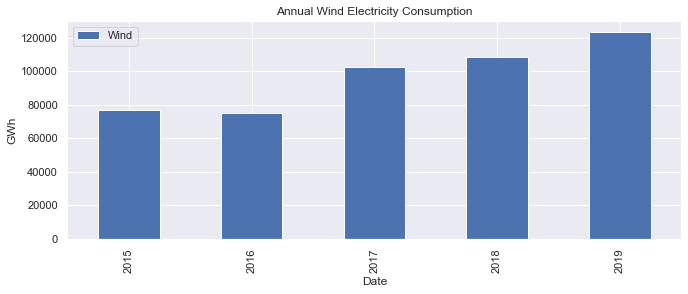

In [41]:
df_test = df[['Wind']].resample('Y').sum()

ax = df_test.set_index(df_test.index.year).plot.bar()
ax.set_title('Annual Wind Electricity Consumption')
ax.set_ylabel('GWh');


Также давайте проверим наличие сезонных составляющих у ряда с ветряной энергией.
    


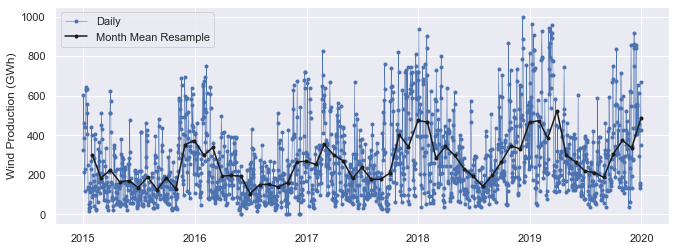

In [42]:
start, end = '2015-01', '2019-12'

fig, ax = plt.subplots()
ax.plot(df.loc[start:end, 'Wind'],marker='.', linestyle='-', linewidth=0.5, label='Daily')
ax.plot(df.resample('M').mean().loc[start:end, 'Wind'], marker='o', markersize=3, linestyle='-', label='Month Mean Resample', color='k')
ax.set_ylabel('Wind Production (GWh)')
ax.legend();


Вероятно, сезонность нестабильна, чтобы это проверить давайте построим boxplot месячных значений

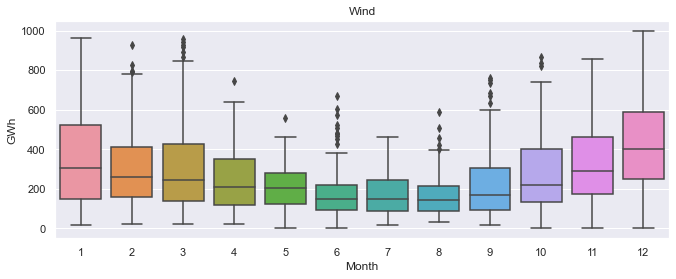

In [43]:
ax = sns.boxplot(data=df, x=df.index.month, y='Wind')
ax.set_ylabel('GWh')
ax.set_xlabel('Month')
ax.set_title('Wind')
plt.show()

На boxplot видно большое количество выброс и изменение среднего значения и дисперсии.

В дополнение мы можем проверить нестационарность сезонности ветровой составляющей с использованием скользящего среднего по годам. Пример показан ниже.

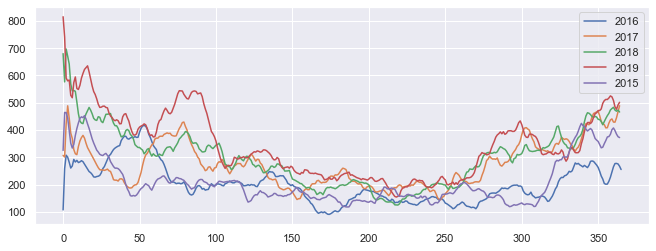

In [44]:
for year in list(set(df.index.year)):
    plt.plot(df.loc[str(year):str(year), 'Wind'].rolling('30d').mean().values, label=year)
plt.legend()    

Вероятно, нестационарность сезонности увеличивается от года к году.   Также оценим сезонность дней недели. 

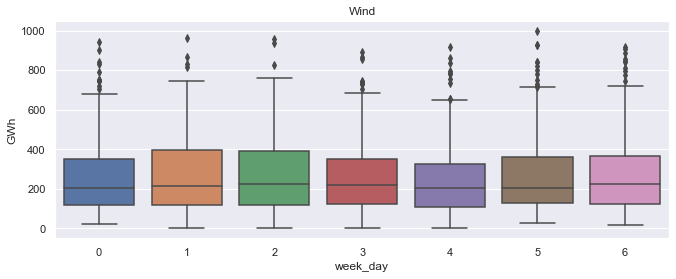

In [45]:
ax = sns.boxplot(data=df, x=df.index.weekday, y='Wind');
ax.set_ylabel('GWh')
ax.set_xlabel('week_day')
ax.set_title('Wind')
plt.show()

на графике не видно явной сезонности или нестационарности, однако число выбросов достаточно большое.
    

В качестве упражнения слушателю предлагается провести анализ солнечной энергии и традиционной энергии